In [4]:
import pandas as pd
import numpy as np
import scipy.stats as st
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

from sklearn.model_selection import KFold, GridSearchCV, train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler

from sklearn.feature_selection import RFECV
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier

from tensorflow.keras import Sequential, Input
from tensorflow.keras.layers import Dense, BatchNormalization
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.metrics import BinaryAccuracy, Precision, Recall

In [5]:
df = pd.read_csv("ks-projects-201801.csv", index_col="ID")

# 前処理

In [6]:
df = df.drop(columns=['pledged', 'backers', 'usd pledged', 'usd_pledged_real', 'goal'])

# 日時に関する変数を TimeStamp に変換
df['deadline'] = pd.to_datetime(df['deadline'])
df['launched'] = pd.to_datetime(df['launched'])
# 期間の変数を作成
df['period'] = (df['deadline'] - df['launched']).dt.days

# 異常値の削除
df = df[df['period'] < 10000] # 異常値の除去
# 欠損値の削除
df = df.dropna(axis=0)

# 目的変数の調整
df = df[(df['state'] == 'successful') | (df['state'] == 'failed')]

df['n_words'] = df['name'].apply(lambda x: len(str(x).split(' ')))

df = df.drop(columns=['name', 'deadline', 'launched', 'country','category'])

# 標準化
stdsc = StandardScaler()
df["usd_goal_real"] = stdsc.fit_transform(df[["usd_goal_real"]].values)

stdsc = StandardScaler()
df["period"] = stdsc.fit_transform(df[["period"]].values)

stdsc = StandardScaler()
df["n_words"] = stdsc.fit_transform(df[["n_words"]].values)

# 説明変数と目的変数の設定
X = df.drop(["state"], axis=1)
df["state"] = [1 if s == "successful" else 0 for s in df["state"]]
y = df["state"]

X = pd.get_dummies(X, drop_first=True)

In [7]:
X

,usd_goal_real,period,n_words,main_category_Comics,main_category_Crafts,main_category_Dance,main_category_Design,main_category_Fashion,main_category_Film & Video,main_category_Food,...,currency_EUR,currency_GBP,currency_HKD,currency_JPY,currency_MXN,currency_NOK,currency_NZD,currency_SEK,currency_SGD,currency_USD
ID,,,,,,,,,,,,,,,,,,,,,
1000002330,-0.036049,1.969999,0.123984,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
1000003930,-0.010379,2.048657,0.842204,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,1
1000004038,0.003147,0.868787,-0.953345,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,1
1000007540,-0.032923,-0.311084,0.483094,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
1000014025,0.007656,0.082206,-0.953345,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
999975836,-0.031571,-0.311084,0.123984,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,1
999977640,-0.036079,-0.547058,-1.312455,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,1
999986353,-0.023906,0.947445,1.919533,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,1


# 特徴選択

In [8]:
# estimatorにモデルをセット
# 今回は回帰問題であるためLinearRegressionを使用
estimator = LinearRegression(normalize=True)

# RFECVは交差検証によってステップワイズ法による特徴選択を行う
# cvにはFold（=グループ）の数，scoringには評価指標を指定する
# 今回は回帰なのでneg_mean_squared_errorを評価指標に指定（分類ならaccuracy）
rfecv = RFECV(estimator, cv=10, scoring='neg_mean_squared_error')

In [9]:
y_est = y.values
X_est = X.values

# fitで特徴選択を実行
rfecv.fit(X, y)

/Users/chibakeigo/miniforge3/envs/suai/lib/python3.9/site-packages/sklearn/linear_model/_base.py:141: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LinearRegression())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)


  warnings.warn(
/Users/chibakeigo/miniforge3/envs/suai/lib/python3.9/site-packages/sklearn/linear_model/_base.py:141: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

fro

RFECV(cv=10, estimator=LinearRegression(normalize=True),
      scoring='neg_mean_squared_error')

In [10]:
# 特徴のランキングを表示（1が最も重要な特徴）
print('Feature ranking: \n{}'.format(rfecv.ranking_))

Feature ranking: 
[1 1 1 1 1 1 1 1 1 1 2 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]


/Users/chibakeigo/miniforge3/envs/suai/lib/python3.9/site-packages/sklearn/utils/deprecation.py:103: FutureWarning: The `grid_scores_` attribute is deprecated in version 1.0 in favor of `cv_results_` and will be removed in version 1.2.
  warnings.warn(msg, category=FutureWarning)


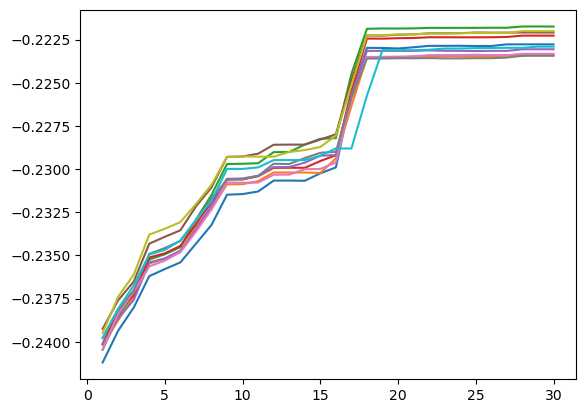

In [11]:
# 特徴数とスコアの変化をプロット
# 負のMSEが評価基準になっており，値がゼロに近いほど汎化誤差は小さい
plt.plot(range(1, len(rfecv.grid_scores_) + 1), rfecv.grid_scores_)
plt.show()

In [12]:
# bool型の配列に ~ をつけるとTrueとFalseを反転させることができる
# ここでTrueになっている特徴が削除してもよい特徴
remove_idx = ~rfecv.support_

# 削除してもよい特徴の名前を取得する
remove_feature = X.columns[remove_idx]
remove_feature

Index(['main_category_Games'], dtype='object')

In [13]:
# drop関数で特徴を削除
selected_X = X.drop(remove_feature, axis=1)
selected_X

,usd_goal_real,period,n_words,main_category_Comics,main_category_Crafts,main_category_Dance,main_category_Design,main_category_Fashion,main_category_Film & Video,main_category_Food,...,currency_EUR,currency_GBP,currency_HKD,currency_JPY,currency_MXN,currency_NOK,currency_NZD,currency_SEK,currency_SGD,currency_USD
ID,,,,,,,,,,,,,,,,,,,,,
1000002330,-0.036049,1.969999,0.123984,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
1000003930,-0.010379,2.048657,0.842204,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,1
1000004038,0.003147,0.868787,-0.953345,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,1
1000007540,-0.032923,-0.311084,0.483094,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
1000014025,0.007656,0.082206,-0.953345,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
999975836,-0.031571,-0.311084,0.123984,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,1
999977640,-0.036079,-0.547058,-1.312455,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,1
999986353,-0.023906,0.947445,1.919533,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,1


# 決定木

In [14]:
X_train, X_test, y_train, y_test = train_test_split(selected_X, y, test_size=0.3)


clf = DecisionTreeClassifier(criterion="gini", max_depth=None, min_samples_split=3, min_samples_leaf=3, random_state=1234)
clf = clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

acc = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f_1 = f1_score(y_test, y_pred)

print(f'正解率: {acc:.3}')
print(f'Precision: {precision:.3}')
print(f'Recall: {recall:.3}')
print(f'F1: {f_1:.3}')

正解率: 0.619
Precision: 0.534
Recall: 0.447
F1: 0.486


# ランダムフォレスト

In [15]:
clf = RandomForestClassifier(n_estimators=100, max_depth=10, criterion="gini",
                                                 min_samples_leaf=5, min_samples_split=2, random_state=1234)
clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)

acc = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f_1 = f1_score(y_test, y_pred)

print(f'正解率: {acc:.3}')
print(f'Precision: {precision:.3}')
print(f'Recall: {recall:.3}')
print(f'F1: {f_1:.3}')

正解率: 0.657
Precision: 0.638
Recall: 0.348
F1: 0.45


# アダブースト

In [16]:
clf = AdaBoostClassifier(DecisionTreeClassifier(max_depth=3,
                                             min_samples_leaf=2,
                                             min_samples_split=2, 
                                             random_state=1234,
                                             criterion="gini"),
                                           n_estimators=10, random_state=1234)
clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)

acc = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f_1 = f1_score(y_test, y_pred)

print(f'正解率: {acc:.3}')
print(f'Precision: {precision:.3}')
print(f'Recall: {recall:.3}')
print(f'F1: {f_1:.3}')

正解率: 0.664
Precision: 0.603
Recall: 0.492
F1: 0.542


# NN

In [17]:
model = Sequential()
model.add(Input(shape=(len(X_train.columns),)))
model.add(Dense(100, activation='relu'))
model.add(BatchNormalization())
model.add(Dense(100, activation='relu'))
model.add(BatchNormalization())
model.add(Dense(100, activation='relu'))
model.add(BatchNormalization())
model.add(Dense(100, activation='relu'))
model.add(BatchNormalization())
model.add(Dense(1, activation='sigmoid'))

model.compile(
    optimizer=Adam(),
    loss=BinaryCrossentropy(),
    metrics=[BinaryAccuracy(), Precision(), Recall()],
)

In [18]:
history = model.fit(
    X_train,
    y_train,
    batch_size=128,
    epochs=10,
    validation_data=(X_test, y_test),
)

Epoch 1/10


2022-11-03 17:39:14.074704: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


1814/1814 [==============================] - 4s 2ms/step - loss: 0.6329 - binary_accuracy: 0.6381 - precision: 0.5732 - recall: 0.4055 - val_loss: 0.6176 - val_binary_accuracy: 0.6525 - val_precision: 0.5940 - val_recall: 0.4431
Epoch 2/10
1814/1814 [==============================] - 3s 2ms/step - loss: 0.6144 - binary_accuracy: 0.6532 - precision: 0.5929 - recall: 0.4499 - val_loss: 0.6138 - val_binary_accuracy: 0.6540 - val_precision: 0.5880 - val_recall: 0.4813
Epoch 3/10
1814/1814 [==============================] - 3s 2ms/step - loss: 0.6094 - binary_accuracy: 0.6588 - precision: 0.6016 - recall: 0.4583 - val_loss: 0.6075 - val_binary_accuracy: 0.6601 - val_precision: 0.5916 - val_recall: 0.5137
Epoch 4/10
1814/1814 [==============================] - 3s 2ms/step - loss: 0.6074 - binary_accuracy: 0.6605 - precision: 0.6031 - recall: 0.4654 - val_loss: 0.6056 - val_binary_accuracy: 0.6609 - val_precision: 0.6142 - val_recall: 0.4334
Epoch 5/10
1814/1814 [=============================

# Day2の結果

正解率: 0.611  
Precision: 0.676  
Recall: 0.0743  
F1: 0.134  